In [21]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations
import copy

import bo_methods_lib
# from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
print(scipy.__version__)

from pympler import asizeof
import gpflow
import tensorflow_probability as tfp

from matplotlib import pyplot as plt

1.13.1


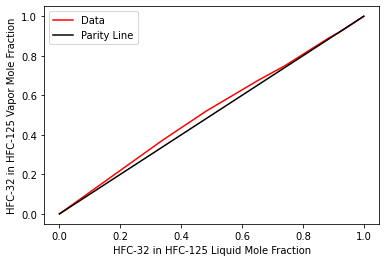

In [ ]:
import matplotlib.pyplot as plt

# Sample data
data = np.array([
    [0, 280.29, 0.83, 0],
    # [0, 295.23, 1.272, 0],
    # [0, 310.61, 1.89, 0],
    # [0, 324.89, 2.639, 0],
    # [0, 339.38, 3.629, 0],
    [0.339, 310.01, 2.08, 0.373],
    # [0.346, 279.83, 0.919, 0.398],
    # [0.347, 295.01, 1.415, 0.387],
    # [0.35, 280.02, 0.924, 0.387],
    # [0.462, 325.07, 3.058, 0.489],
    # [0.465, 310, 2.15, 0.498],
    # [0.47, 295.03, 1.461, 0.508],
    [0.482, 280.06, 0.955, 0.52],
    # [0.644, 324.97, 3.174, 0.661],
    # [0.646, 309.96, 2.227, 0.672],
    # [0.65, 279.95, 0.985, 0.676],
    [0.653, 295.06, 1.516, 0.676],
    [0.74, 340.18, 4.482, 0.749],
    [0.885, 340.17, 4.572, 0.89],
    [0.914, 295.03, 1.559, 0.915],
    [0.915, 310.08, 2.303, 0.914],
    [0.919, 325.17, 3.297, 0.919],
    [0.919, 340.17, 4.582, 0.919],
    [0.948, 280.07, 1.017, 0.947],
    [0.948, 294.94, 1.556, 0.947],
    [1, 280, 1.008, 1],
    # [1, 293.99, 1.515, 1],
    # [1, 310.51, 2.329, 1],
    # [1, 325.49, 3.318, 1],
    # [1, 340.08, 4.572, 1]
])

x = data[:,0]
y = data[:,-1]



# Create figure and axis
fig, ax = plt.subplots()

# Plot data
ax.plot(x, y, color = 'red', label = 'VLE Data')
ax.plot(x, x, color = 'black', label = "x=y")
ax.legend()

# Labels and title
ax.set_xlabel('HFC-32 in HFC-125 Liquid Mole Fraction')
ax.set_ylabel('HFC-32 in HFC-125 Vapor Mole Fraction')
# ax.set_title('Plot Title')

# Grid
# ax.grid(True)

# Show plot
plt.show()

In [2]:
#Set Parameters
cs_name_val = 10
ep0 = 1 #Set initial ep as an even mix between exploration and exploitation
ep_enum_val = 1
meth_name_val = 1
sep_fact = 1.0
gen_heat_map_data = False
normalize = True
noise_mean = 0
noise_std = None
kernel_enum_val = 1
lenscl = None #list([0.136113749, 221.573761, 830.968019, 1.67917241, 0.3, 0.2])
outputscl = None
retrain_GP = 4
reoptimize_obj = 4
bo_iter_tot = 3
bo_run_total = 2
runs_per_job_max = 1
bo_runs_in_job = bo_run_total
save_data = False
ei_tol = 1e-7
obj_tol = 1e-7
num_x_data = 5
gen_meth_theta = 1
gen_meth_x = 2
gen_meth_theta_val = 1
num_val_pts = 0
num_theta_multiplier = 10 #How many simulation data points to generate is equal to num_theta_multiplier*number of parameters
seed = 1
sim_seed = 1
noise_std_pct = 0.0
gen_y_sse = True
w_noise = False

In [3]:
# Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(meth_name_val)
method = GPBO_Methods(meth_name)
ep_enum = Ep_enum(ep_enum_val)
kernel = Kernel_enum(kernel_enum_val)
lenscl = lenscl
try:
    lenscl = json.loads(lenscl)
except:
    lenscl = lenscl


#All simulator objects will have the same seed. This keeps restarts/jobs consistent for data generation
simulator = simulator_helper_test_fxns(
    cs_name_val, noise_mean, noise_std, sim_seed
)

# Generate Exp Data (OR Add your own experimental data as a Data class object)
gen_meth_x = Gen_meth_enum(gen_meth_x)
if cs_name_val == 16:
    x_vals = np.array([0.0,0.1115,0.2475,0.4076,0.5939,0.8230,0.9214,0.9296,0.985,1.000])
elif cs_name_val == 17:
    x_vals = np.array([0.0087,0.0269,0.0568,0.1556,0.2749,0.4449,0.661,0.8096,0.9309,0.9578])    
else:
    x_vals = None

# Set simulator noise_std artifically as 1% of y_exp median (So that noise will be set rather than trained)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, x_vals, noise_std_pct)

print(np.median(exp_data.y_vals)*0.01)

# # Create Exploration Bias Class
# if ep_enum.value == 1:
#     # Constant value stays constant
#     ep_bias = Exploration_Bias(
#         ep0, None, ep_enum, None, None, None, None, None, None, None
#     )
# elif ep_enum.value == 2:
#     # For decay method, decay from mixed to full exploitation (alpha of 0.5) for this example
#     ep_bias = Exploration_Bias(
#         ep0,
#         None,
#         ep_enum,
#         None,
#         bo_iter_tot,
#         None,
#         0.5,
#         None,
#         None,
#         None,
#     )
# elif ep_enum.value == 3:
#     # Set ep multiplier to 1.5 as recommended in Boyle
#     ep_bias = Exploration_Bias(
#         ep0, None, ep_enum, None, None, 1.5, None, None, None, None
#     )
# elif ep_enum.value == 4:
#     # Jasrasaria method will take care of itself
#     ep_bias = Exploration_Bias(
#         None, None, ep_enum, None, None, None, None, None, None, None
#     )
# else:
#     raise Warning("Ep_enum value must be between 1 and 4!")

# # Generate Sim (Training) Data (OR Add your own training data here as a Data class object)
# num_theta_data = len(simulator.indices_to_consider) * num_theta_multiplier
# gen_meth_theta = Gen_meth_enum(gen_meth_theta)
# # Note at present, training data is always the same between jobs since we set the data generation seed to 1    
# # simulator.noise_std = np.abs(np.median(exp_data.y_vals)) * noise_std_pct #Manually set noise std
# sim_data = simulator.gen_sim_data(
#     num_theta_data,
#     num_x_data,
#     gen_meth_theta,
#     gen_meth_x,
#     sep_fact,
#     sim_seed,
#     False,
#     x_vals,
#     w_noise = False
# )

# y_to_sse = False
# # Gen sse_sim_data and sse_sim_val_data
# sim_sse_data = simulator.sim_data_to_sse_sim_data(
#     method, sim_data, exp_data, sep_fact, y_to_sse
# )

# # Generate validation data if applicable. This is only useful for small (<4 Params + 1 State Point). Otherwise this takes up too much memory
# if num_val_pts > 0:
#     gen_meth_theta_val = Gen_meth_enum(
#         gen_meth_theta_val
#     )  # input is an integer (1 or 2)
#     val_data = simulator.gen_sim_data(
#         num_val_pts,
#         num_x_data,
#         gen_meth_theta_val,
#         gen_meth_x,
#         sep_fact,
#         None,
#         True,
#         x_vals
#     )
#     y_to_sse = True
#     val_sse_data = simulator.sim_data_to_sse_sim_data(
#         method, val_data, exp_data, sep_fact, y_to_sse
#     )
# # Set validation data to None if not generating it
# else:
#     val_data = None
#     val_sse_data = None
#     gen_meth_theta_val = gen_meth_theta_val  # Value is None

# # Define cs_name and cs_params class
# cs_name = get_cs_class_from_val(cs_name_val).name #Save name of case study here
# # Signac saves all BO_Results in different folders, so they can have the same name
# cs_params = CaseStudyParameters(
#     cs_name,
#     ep0,
#     sep_fact,
#     normalize,
#     kernel,
#     lenscl,
#     outputscl,
#     retrain_GP,
#     reoptimize_obj,
#     gen_heat_map_data,
#     bo_iter_tot,
#     bo_runs_in_job,
#     save_data,
#     None,
#     seed,
#     ei_tol,
#     obj_tol,
#     gen_y_sse,
#     w_noise,
# )
# # Initialize driver class
# driver = GPBO_Driver(
#     cs_params,
#     method,
#     simulator,
#     exp_data,
#     sim_data,
#     sim_sse_data,
#     val_data,
#     val_sse_data,
#     None,
#     ep_bias,
#     gen_meth_theta,
# )
# # Get results
# gpbo_res_simple, gpbo_res_GP = driver.run_bo_restarts()

# #Define a path for the data. (Use the name of the case study and date)
# #Get Date only from DateTime String
# # savepath1 = "A_BO_Results.gz"
# # fileObj1 = gzip.open(savepath1, "wb", compresslevel=1)
# # pickled_results1 = pickle.dump(gpbo_res_simple, fileObj1)
# # fileObj1.close()

# # savepath2 = "A_BO_Results_GPs.gz"
# # fileObj2 = gzip.open(savepath2, "wb", compresslevel=2)
# # pickled_results2 = pickle.dump(gpbo_res_GP, fileObj2)
# # fileObj2.close()

0.0


In [4]:
gpbo_res_simple[1].results_df.iloc[:,0:13]

NameError: name 'gpbo_res_simple' is not defined

In [ ]:
from bo_methods_lib.bo_methods_lib.analyze_data import General_Analysis, open_file_helper
results1 = open_file_helper("GPBO_nonoise/workspace/4d801efc09d4003701818420c187a881/BO_Results.gz")
# results2 = open_file_helper("GPBO_test/workspace/8bab17d551702f04d63b2831d31f47e7/B_BO_Results.gz")
# # results2 = open_file_helper("GPBO_test/workspace/c0a28e1708bd32a1bfb6fc18eeb6948e/BO_Results.gz")
# results3 = open_file_helper("GPBO_test/workspace/7a2f5519750598c1a0d9f6b880e22745/BO_Results.gz")
results1[0].results_df.iloc[:,0:13]
# results1[0].results_df.columns

,Best Error,Exploration Bias,Theta Opt Acq,Opt Acq,Acq Obj Act,MSE Acq Act,Theta Min Obj,Min Obj GP,Min Obj Act,MSE Obj GP,MSE Obj Act,Time/Iter
0,4.656151,1.0,"[0.3469536854788238, 4.521604310954847, 2.6332...",55.810940,0.346865,0.013875,"[0.34195445541426883, 4.630364649849065, 1.766...",0.028618,0.346865,0.001145,0.013875,8566.952072
1,0.038693,1.0,"[0.3265039992016805, 5.269015208055798, 2.9013...",12.148798,0.433190,0.017328,"[0.33918962643354944, 4.588921429879259, 1.708...",0.052356,0.433190,0.002094,0.017328,10952.229008
2,0.038693,1.0,"[0.3517454772898683, 4.194056664957915, 3.2361...",10.558233,0.281955,0.011278,"[0.32057389357390337, 4.482456088562311, 2.008...",0.155221,0.281955,0.006209,0.011278,10196.464058
3,0.038693,1.0,"[0.35723994879393106, 3.9354114587964566, 3.30...",29.635144,0.052993,0.002120,"[0.3412300758044867, 4.512024806684217, 2.5337...",0.069574,0.052993,0.002783,0.002120,11228.879250
4,0.038693,1.0,"[0.37923515669298036, 6.087488038281057, 2.489...",0.659851,66.530607,2.661224,"[0.0, 3.272182788034806, 0.01, 0.0]",22.298771,66.530607,0.891951,2.661224,2274.693935
5,0.038693,1.0,"[0.33895117612791686, 4.5023756381896245, 2.84...",1.196507,1.081380,0.043255,"[0.3051291296949563, 4.778193123663427, 2.9437...",0.518791,1.081380,0.020752,0.043255,7408.758207
6,0.038693,1.0,"[0.3372970339254905, 4.32138600412916, 3.27033...",21.295653,0.107131,0.004285,"[0.3530781534395495, 4.452512959536479, 2.7686...",0.094803,0.107131,0.003792,0.004285,16764.681908
7,0.038693,1.0,"[0.36308981373564764, 4.506166066666749, 2.179...",17.790264,0.031809,0.001272,"[0.3505890421692924, 4.502472254280697, 2.6457...",0.029877,0.031809,0.001195,0.001272,12463.290035
8,0.038693,1.0,"[0.3600329051352218, 3.4065378724477613, 2.657...",19.161433,0.237006,0.009480,"[0.33406062210501414, 4.578993687683563, 1.917...",0.125853,0.237006,0.005034,0.009480,10222.301727
9,0.038693,1.0,"[0.33116726008580694, 3.178087959619898, 3.291...",13.440015,0.237607,0.009504,"[0.3544629627260525, 4.3345423513098655, 2.648...",0.238198,0.237607,0.009528,0.009504,10792.885511


In [ ]:
results2[1].results_df.iloc[:,0:13]